In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
import pandas as pd

# Load the data into a new DataFrame
new_df = pd.read_excel(r"C:\Users\drash\OneDrive\Documents\Extra\Manan Sir\2019\2019\my_dataframe.xlsx")

# Drop the columns
new_df = new_df.drop(['From Date', 'To Date'], axis=1)

# If you need to convert to a numpy array
data = new_df.values


In [4]:
data = new_df.values.reshape(-1, 1)

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
look_back = 3
supervised_data = series_to_supervised(scaled_data, n_in=look_back, n_out=1)
X = supervised_data.iloc[:, :-1].values
y = supervised_data.iloc[:, -1].values

In [8]:
# Split data into train and test (customize as needed)
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Reshape input to [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/50
361/361 [==============================] - 4s 5ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 2/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 3/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0094 - val_loss: 0.0077
Epoch 4/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 5/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 6/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 7/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 8/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 9/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 10/50
361/361 [==============================] - 1s 3ms/step - loss: 0.0085 - val_loss: 0.0067

In [10]:
# Predict and rescale
yhat = model.predict(X_test)
yhat_rescaled = scaler.inverse_transform(yhat)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


91/91 [==============================] - 1s 2ms/step


In [11]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

# Load dataset and drop unnecessary columns
df = pd.read_excel(r"C:\Users\drash\OneDrive\Documents\Extra\Manan Sir\2019\2019\my_dataframe.xlsx")
df = df.drop(['From Date', 'To Date'], axis=1)
values = df.values.astype('float32')

# Normalize features
# Only using PM2.5 values for scaling
values = df['PM2.5'].values.reshape(-1, 1) # Replace 'YOUR_PM2.5_COLUMN_NAME' with the correct column name



scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Function to create dataset with look-back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Adjusting the look-back period
look_back = 3
X, y = create_dataset(scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting data into train and test sets
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

# Adjusting the LSTM architecture
model = Sequential()
model.add(LSTM(100, input_shape=(look_back, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1, shuffle=False)

# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform predictions back to original scale
train_predict_original = scaler.inverse_transform(train_predict)
y_train_original = scaler.inverse_transform([y_train])
test_predict_original = scaler.inverse_transform(test_predict)
y_test_original = scaler.inverse_transform([y_test])

# RMSE calculations
train_score = np.sqrt(mean_squared_error(y_train_original[0], train_predict_original[:, 0]))
print('Train RMSE: ', train_score)
test_score = np.sqrt(mean_squared_error(y_test_original[0], test_predict_original[:, 0]))
print('Test RMSE: ', test_score)


Epoch 1/50
8/8 [==============================] - 5s 119ms/step - loss: 0.2685 - val_loss: 0.1853
Epoch 2/50
8/8 [==============================] - 0s 19ms/step - loss: 0.1342 - val_loss: 0.0529
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0279
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0319 - val_loss: 0.0158
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0171 - val_loss: 0.0183
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0196 - val_loss: 0.0154
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0174 - val_loss: 0.0149
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0170 - val_loss: 0.0145
Epoch 9/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0173 - val_loss: 0.0147
Epoch 10/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0167 - val_loss: 0.0144
Epoch 11/50
8/8 [===========

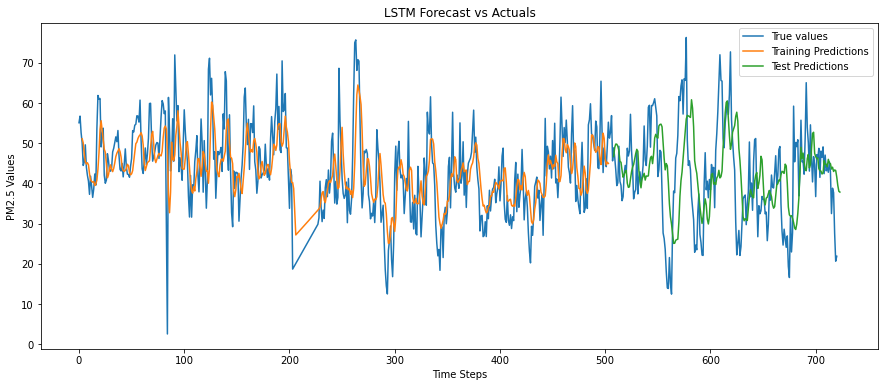

In [12]:
import matplotlib.pyplot as plt

# Plotting the actual and predicted values for the training set
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled), label='True values')
plt.plot(range(look_back, len(train_predict) + look_back), train_predict_original, label='Training Predictions')
plt.plot(range(len(train_predict) + (2 * look_back) + 1, len(train_predict) + (2 * look_back) + 1 + len(test_predict_original)), test_predict_original, label='Test Predictions')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Values')
plt.title('LSTM Forecast vs Actuals')
plt.legend()
plt.show()


In [13]:
n_future = 10  # for example, if you want to predict the next 10 time steps

# Take the last `look_back` periods from the original scaled dataset
input_sequence = scaled[-look_back:].tolist()

future_predictions = []

# Forecast using the model
for _ in range(n_future):
    # Predict the next value
    next_prediction = model.predict(np.array(input_sequence[-look_back:]).reshape(1, look_back, 1))
    # Append the prediction to the input sequence and future_predictions list
    input_sequence.append(next_prediction[0].tolist())
    future_predictions.append(next_prediction[0])

# Transform future_predictions back to the original scale
future_predictions_original = scaler.inverse_transform(future_predictions)

print(future_predictions_original)


1/1 [==============================] - 0s 17ms/step
[[30.11980456]
 [29.84418973]
 [31.99044028]
 [34.40958609]
 [35.21248182]
 [36.47121424]
 [37.5023677 ]
 [38.17833642]
 [38.8676239 ]
 [39.41584623]]


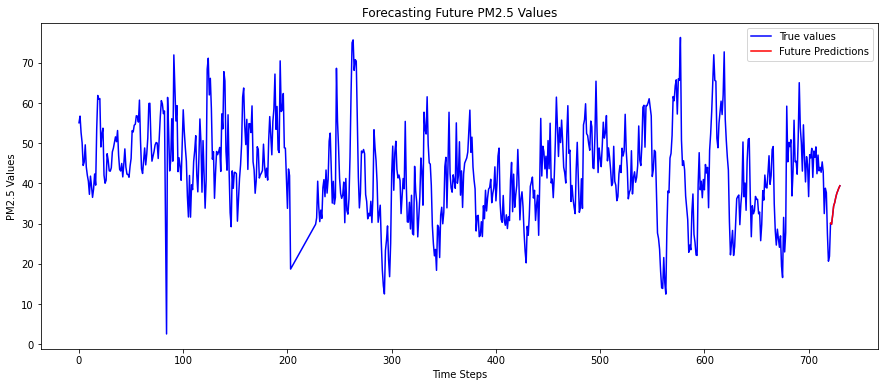

In [14]:
import matplotlib.pyplot as plt

# Extract the length of the original scaled data
len_data = len(scaled)

# Combine the original data and future predictions
combined_data = np.concatenate((scaler.inverse_transform(scaled), future_predictions_original))

# Create a new figure
plt.figure(figsize=(15, 6))

# Plot the entire combined data as 'True values'
plt.plot(combined_data, label='True values', color='blue')

# Plot the future predictions segment in red, starting from the end of the original data
plt.plot(range(len_data, len_data + n_future), future_predictions_original, color='red', label='Future Predictions')

# Set title, labels, and legend
plt.title('Forecasting Future PM2.5 Values')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Values')
plt.legend()

# Display the plot
plt.show()


In [15]:
from sklearn.metrics import r2_score

# Generate predictions for the training set
train_predictions_scaled = model.predict(X_train)
train_predictions_original = scaler.inverse_transform(train_predictions_scaled)

# Generate predictions for the test set
test_predictions_scaled = model.predict(X_test)
test_predictions_original = scaler.inverse_transform(test_predictions_scaled)

# Calculate the R^2 score for the training set
r2_train = r2_score(y_train_original[0], train_predictions_original)

# Calculate the R^2 score for the test set
r2_test = r2_score(y_test_original[0], test_predictions_original)

print(f"R^2 score for the training set: {r2_train:.4f}")
print(f"R^2 score for the test set: {r2_test:.4f}")


7/7 [==============================] - 0s 2ms/step
R^2 score for the training set: 0.4244
R^2 score for the test set: 0.5333


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE calculations
train_mse = mean_squared_error(y_train_original[0], train_predict_original[:, 0])
print('Train MSE: ', train_mse)

test_mse = mean_squared_error(y_test_original[0], test_predict_original[:, 0])
print('Test MSE: ', test_mse)

# MAE calculations
train_mae = mean_absolute_error(y_train_original[0], train_predict_original[:, 0])
print('Train MAE: ', train_mae)

test_mae = mean_absolute_error(y_test_original[0], test_predict_original[:, 0])
print('Test MAE: ', test_mae)



Train MSE:  71.51804707895032
Test MSE:  69.42788032991388
Train MAE:  6.396993679115158
Test MAE:  6.670482966105144
